___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [93]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import random

In [94]:
plt.rcParams['text.usetex'] = False

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [95]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [97]:
# Define transformations with Data Augmentation
# Apply the same random augmentations to both low-res and high-res images
class PairedTransform:
    def __init__(self):
        # Define augmentations that should be applied identically to both images
        self.angle = transforms.RandomRotation.get_params([-15, 15])
        self.hflip = random.random() > 0.5
        self.vflip = random.random() > 0.5

    def __call__(self, low_res_img, high_res_img):
        # Apply Rotation
        low_res_img = TF.rotate(low_res_img, self.angle)
        high_res_img = TF.rotate(high_res_img, self.angle)

        # Apply Horizontal Flip
        if self.hflip:
            low_res_img = TF.hflip(low_res_img)
            high_res_img = TF.hflip(high_res_img)

        # Apply Vertical Flip
        if self.vflip:
            low_res_img = TF.vflip(low_res_img)
            high_res_img = TF.vflip(high_res_img)

        # Convert to Tensor (after geometric augmentations)
        low_res_img = TF.to_tensor(low_res_img)
        high_res_img = TF.to_tensor(high_res_img)

        return low_res_img, high_res_img

class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, use_augmentation=False):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.use_augmentation = use_augmentation
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images as PIL Images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res (if needed, ensures 128x128 input)
        if low_res.size != (128, 128):
             low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.use_augmentation:
            augment_transform = PairedTransform()
            low_res, high_res = augment_transform(low_res, high_res)
        else:
            # Just convert to tensor if no augmentation
            low_res = TF.to_tensor(low_res)
            high_res = TF.to_tensor(high_res)

        return low_res, high_res

# Create the dataset for training images WITH augmentation
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', use_augmentation=True)
# Create the dataset for validation images WITHOUT augmentation
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', use_augmentation=False)


# Function to create data loader
def create_loader(dataset, batch_size, shuffle_data=True): # Added shuffle_data flag
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the training dataset:', dataset_size)
print('Number of images in the validation dataset:', len(val_dataset))

Number of images in the training dataset: 240
Number of images in the validation dataset: 30


___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [98]:
class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # Enabled BatchNorm
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), # Enabled
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), # Enabled
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling using PixelShuffle then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Convolution before PixelShuffle. Output channels = target_channels * scale_factor^2
        # Target channels after upsampling = out_channels (matching skip connection)
        self.conv_before_ps = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.ps = nn.PixelShuffle(2) # Upsample by 2x
        # ConvBlock takes concatenated input: out_channels (from PS) + out_channels (from skip) = 2 * out_channels
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x1, x2):
        # x1: feature map from lower layer (e.g., 16x16x512)
        # x2: feature map from corresponding encoder layer (skip connection) (e.g., 32x32x256)
        x1 = self.conv_before_ps(x1) # -> 16x16x(256*4)
        x1 = self.ps(x1) # -> 32x32x256

        # Pad x1 if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        if diffX != 0 or diffY != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1) # -> 32x32x(256+256) = 32x32x512
        return self.conv(x) # -> 32x32x256 (out_channels)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # <<< DEBUG: Print shape right before OutConv's internal conv2d >>>
        # print(f"DEBUG: Input shape to OutConv layer: {x.shape}")
        return self.conv(x)

class UNetPixelShuffle(nn.Module): # Renamed class
    def __init__(self, n_channels=1, n_classes=1):
        super(UNetPixelShuffle, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512) # Bottleneck

        # Decoder (using Up with PixelShuffle)
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)

        # Final Convolution
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # <<< DEBUG: Print initial input shape >>>
        # print(f"DEBUG: Initial Model Input shape: {x.shape}")

        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        # Decoder path
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)

        # <<< DEBUG: Print shape before F.interpolate >>>
        # print(f"DEBUG: Shape before F.interpolate: {x.shape}")

        # Upsample output of up3 block to final size
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        # <<< DEBUG: Print shape after F.interpolate (before OutConv) >>>
        # print(f"DEBUG: Shape after F.interpolate: {x.shape}")

        logits = self.outc(x)

        # <<< DEBUG: Print final output shape >>>
        # print(f"DEBUG: Final Model Output shape: {logits.shape}")

        return logits

___
### Create a function to execute training. Note, we will call this function later.

In [99]:
def train_model(model, opt, criterion, scheduler, train_loader, val_loader, num_epoch, patience=10): # Added scheduler, val_loader, patience
    train_losses = []
    val_scores = []
    best_val_score = -float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Metrics for validation
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)


    for epoch in range(num_epoch):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        print(f'--- Epoch {epoch+1}/{num_epoch} ---')
        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            opt.zero_grad()
            y_hat_tr_batch = model(x_tr_batch)
            loss = criterion(y_hat_tr_batch, y_tr_batch)
            loss.backward()
            opt.step()
            total_train_loss += loss.item()

            if (i + 1) % 20 == 0: # Print more often if dataset is large
                print(f'Iteration {i+1}/{len(train_loader)}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1} Average Training Loss: {avg_train_loss:.6f}')

        # --- Validation Phase ---
        model.eval()
        total_val_psnr = 0
        total_val_ssim = 0
        with torch.no_grad():
            for x_val_batch, y_val_batch in val_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                y_hat_val_batch = model(x_val_batch)

                # Ensure correct range for SSIM if needed (e.g., if output isn't strictly 0-1)
                data_range = y_val_batch.max() - y_val_batch.min()
                ssim_metric.data_range = data_range

                total_val_psnr += psnr_metric(y_hat_val_batch, y_val_batch).item()
                total_val_ssim += ssim_metric(y_hat_val_batch, y_val_batch).item()

        avg_val_psnr = total_val_psnr / len(val_loader.dataset) # Divide by num samples, not batches
        avg_val_ssim = total_val_ssim / len(val_loader.dataset) # Divide by num samples, not batches
        current_val_score = avg_val_psnr + 40 * avg_val_ssim
        val_scores.append(current_val_score)

        print(f'Epoch {epoch+1} Validation PSNR: {avg_val_psnr:.2f} dB, SSIM: {avg_val_ssim:.4f}, Score: {current_val_score:.2f}')

        # Learning Rate Step
        scheduler.step()
        print(f"Epoch {epoch+1} Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # --- Early Stopping & Best Model Saving ---
        if current_val_score > best_val_score:
            best_val_score = current_val_score
            epochs_no_improve = 0
            # Save the best model state dictionary
            best_model_state = model.state_dict()
            print(f'---> New best score: {best_val_score:.2f}. Saving model state.')
            # Optional: Save checkpoint to disk here if needed
            # torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        else:
            epochs_no_improve += 1
            print(f'Score did not improve for {epochs_no_improve} epoch(s).')

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training L1 Loss', color=color)
    ax1.plot(range(1, len(train_losses) + 1), train_losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_yscale('log') # Keep log scale for loss

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Validation Score (PSNR + 40*SSIM)', color=color)
    ax2.plot(range(1, len(val_scores) + 1), val_scores, color=color, label='Validation Score')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Training Loss and Validation Score')
    # Combine legends if needed, or just rely on axis labels
    # fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid(True)
    plt.show()

    # Load the best model state before returning
    if best_model_state:
        print(f"Loading model state from epoch {epoch + 1 - epochs_no_improve} with best score: {best_val_score:.2f}")
        model.load_state_dict(best_model_state)

    return model # Return the best model

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Starting Training...
--- Epoch 1/300 ---
Iteration 20/48, Loss: 0.056618
Iteration 40/48, Loss: 0.043708
Epoch 1 Average Training Loss: 0.112641
Epoch 1 Validation PSNR: 3.07 dB, SSIM: 0.0812, Score: 6.32
Epoch 1 Learning Rate: 0.000200
---> New best score: 6.32. Saving model state.
--- Epoch 2/300 ---
Iteration 20/48, Loss: 0.036762
Iteration 40/48, Loss: 0.028458
Epoch 2 Average Training Loss: 0.038817
Epoch 2 Validation PSNR: 5.67 dB, SSIM: 0.1621, Score: 12.16
Epoch 2 Learning Rate: 0.000200
---> New best score: 12.16. Saving model state.
--- Epoch 3/300 ---
Iteration 20/48, Loss: 0.037763
Iteration 40/48, Loss: 0.043734
Epoch 3 Average Training Loss: 0.034543
Epoch 3 Validation PSNR: 4.94 dB, SSIM: 0.1596, Score: 11.32
Epoch 3 Learning Rate: 0.000200
Score did not improve for 1 epoch(s).
--- Epoch 4/300 ---
Iteration 20/48, Loss: 0.034018
Iteration 40/48, Loss: 0.041121
Epoch 4 Average Training Loss: 0.033257
Epoch 4 Validation PSNR: 5.97 dB, SSIM: 0.1735, Score: 12.91
Epoch 4 Lea

findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.


Epoch 59 Average Training Loss: 0.023920
Epoch 59 Validation PSNR: 6.10 dB, SSIM: 0.1649, Score: 12.70
Epoch 59 Learning Rate: 0.000200
Score did not improve for 20 epoch(s).
Early stopping triggered after 59 epochs.


findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Fo

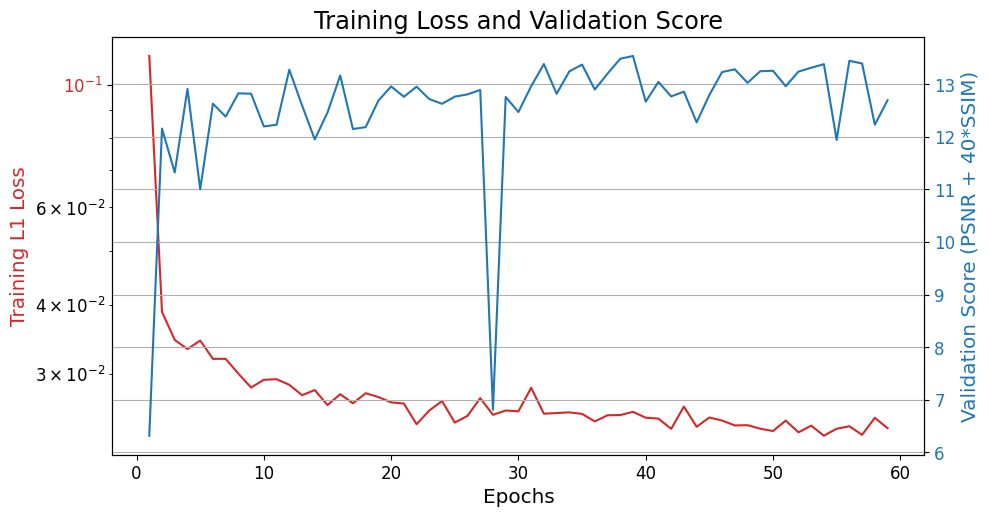

Loading model state from epoch 39 with best score: 13.54
Training Finished.


In [100]:
batch_size = 5
# lr = 1e-4 # Keep initial LR
lr = 0.0002 # Common starting LR for Adam with generators
num_epoch = 300  # Increased Epochs
early_stopping_patience = 20 # Stop after 20 epochs of no improvement

# Data Loaders
train_loader = create_loader(train_dataset, batch_size, shuffle_data=True)
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False) # No shuffle for validation

# Model, criterion, optimizer, scheduler
model = UNetPixelShuffle().to(device)  # Use the updated model name
criterion = nn.L1Loss()  # Changed to L1 Loss
opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999)) # Specify betas often helps
scheduler = optim.lr_scheduler.StepLR(opt, step_size=num_epoch // 3, gamma=0.1) # Decrease LR at 1/3 and 2/3 of total epochs

# Train the model (Now also performs validation and early stopping)
print("Starting Training...")
model = train_model(model, opt, criterion, scheduler, train_loader, val_loader, num_epoch, early_stopping_patience)
print("Training Finished.")


___
### Apply it one of the validation image

findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Font family 'cm' not found.
findfont: Fo

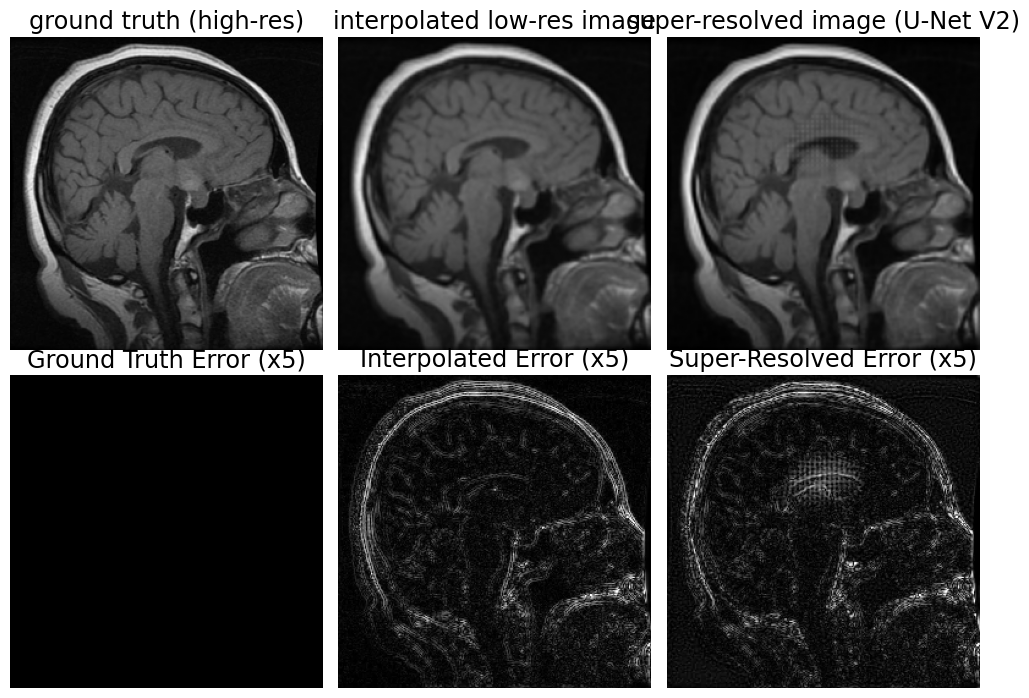

In [101]:
val_low_res, val_high_res = val_dataset[1]  # Input (1x128x128), Ground truth (1x256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device) #

# Upsample low-resolution image to 256x256 *only for visualization comparison*
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0) #

# Apply the TRAINED model (best version loaded in train_model)
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    # Add batch dimension to low-res input
    val_super_res = model(val_low_res.unsqueeze(0)).squeeze(0)  # Input: 1x1x128x128 -> Output: 1x1x256x256 -> Squeeze: 1x256x256

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the *interpolated* version for visualization
val_high_res_np = val_high_res.squeeze().cpu().numpy() #
# Clamp output to [0, 1] for visualization, as L1 loss doesn't guarantee this range
val_super_res_np = torch.clamp(val_super_res, 0, 1).squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7)) #

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1) #
ax[0, 0].set_title('ground truth (high-res)') #
ax[0, 0].axis('off') #

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1) #
ax[0, 1].set_title('interpolated low-res image') #
ax[0, 1].axis('off') #

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1) #
ax[0, 2].set_title('super-resolved image (U-Net V2)') # Updated Title
ax[0, 2].axis('off') #

# Error maps (Multiplied by 5 for visibility)
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1) #
ax[1, 0].set_title('Ground Truth Error (x5)') #
ax[1, 0].axis('off') #

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1) #
ax[1, 1].set_title('Interpolated Error (x5)') #
ax[1, 1].axis('off') #

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1) #
ax[1, 2].set_title('Super-Resolved Error (x5)') #
ax[1, 2].axis('off') #

plt.tight_layout() #
plt.show() #

### Compute PSNR and SSIM over the entire validation dataset

In [102]:
print("--- Calculating Final Metrics on Validation Set using Best Model ---")

# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device) #
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device) #

# Accumulators
total_psnr_interpolated = 0 #
total_psnr_super_resolved = 0 #
total_ssim_interpolated = 0 #
total_ssim_super_resolved = 0 #
num_samples = len(val_dataset) #
val_loader_final = create_loader(val_dataset, batch_size=1, shuffle_data=False) # Use batch_size=1 for final eval if needed

model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # Disable gradients for evaluation
    # Loop over validation set
    for val_low_res, val_high_res in val_loader_final: # Using loader simplifies batching
        val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device) # Already batched

        # Compute data range dynamically for SSIM
        data_range = val_high_res.max() - val_high_res.min() #
        ssim_metric.data_range = data_range #

        # --- Evaluation for Interpolated Image ---
        val_low_res_interpolated_batch = torch.nn.functional.interpolate(val_low_res, scale_factor=2, mode='bicubic', align_corners=False) #
        psnr_interp = psnr_metric(val_low_res_interpolated_batch, val_high_res).item() #
        ssim_interp = ssim_metric(val_low_res_interpolated_batch, val_high_res).item() #

        # --- Evaluation for Super-Resolved Image (U-Net V2) ---
        val_super_res_batch = model(val_low_res) # Get model output
        # Clamp output for metrics if necessary (e.g., if model output exceeds [0,1])
        val_super_res_batch_clamped = torch.clamp(val_super_res_batch, 0, 1)

        psnr_sr = psnr_metric(val_super_res_batch_clamped, val_high_res).item() #
        ssim_sr = ssim_metric(val_super_res_batch_clamped, val_high_res).item() #

        # Accumulate metrics (Handling batch size > 1 if used, though 1 is recommended here)
        total_psnr_interpolated += psnr_interp * val_low_res.size(0) # Multiply by batch size
        total_psnr_super_resolved += psnr_sr * val_low_res.size(0)
        total_ssim_interpolated += ssim_interp * val_low_res.size(0)
        total_ssim_super_resolved += ssim_sr * val_low_res.size(0)

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples #
avg_psnr_sr = total_psnr_super_resolved / num_samples #
avg_ssim_interp = total_ssim_interpolated / num_samples #
avg_ssim_sr = total_ssim_super_resolved / num_samples #

# Calculate the combined score for the super-resolved images
score_sr = avg_psnr_sr + 40 * avg_ssim_sr
score_interp = avg_psnr_interp + 40 * avg_ssim_interp

# Print results
print(f'--- Final Validation Set Performance (Best Model) ---') #
print(f'Average PSNR (Bicubic Interpolated): {avg_psnr_interp:.2f} dB') #
print(f'Average PSNR (U-Net V2 Super-Resolved): {avg_psnr_sr:.2f} dB') #
print(f'Average SSIM (Bicubic Interpolated): {avg_ssim_interp:.4f}') #
print(f'Average SSIM (U-Net V2 Super-Resolved): {avg_ssim_sr:.4f}') #
print(f'Combined Score (Interpolated): {score_interp:.2f}')
print(f'Combined Score (U-Net V2 Super-Resolved): {score_sr:.2f}')

--- Calculating Final Metrics on Validation Set using Best Model ---
--- Final Validation Set Performance (Best Model) ---
Average PSNR (Bicubic Interpolated): 30.81 dB
Average PSNR (U-Net V2 Super-Resolved): 30.47 dB
Average SSIM (Bicubic Interpolated): 0.9056
Average SSIM (U-Net V2 Super-Resolved): 0.8458
Combined Score (Interpolated): 67.04
Combined Score (U-Net V2 Super-Resolved): 64.30
